In [7]:
# Install and load packages
install.packages("MASS")
install.packages("glmnet")
install.packages("parallel")
install.packages("boot")
install.packages("randomForest")
install.packages("caret")
install.packages("e1071")

library(MASS)
library(glmnet)
library(parallel)
library(boot)
library(randomForest)
library(caret)
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘parallel’ is a base package, and should not be updated”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



reproduce the figure 1 results

In [2]:
# Simulate data and fit a logistic regression model

simulate_and_fit <- function(n, p, num_nonnull, ar_coeff, scenario) {
  # generate AR(1) structure
  Sigma <- outer(1:p, 1:p, FUN = function(i, j) ar_coeff^abs(i - j))
  #design matrix x and corresponding binary response variable y
  X <- MASS::mvrnorm(n = n, mu = rep(0, p), Sigma = Sigma)
  if (scenario == "global_null") {
    Y <- rbinom(n, 1, 0.5)
  } else if (scenario == "20_nonzero") {
    logit_p <- 0.08 * rowSums(X[, 2:21])
    prob <- exp(logit_p) / (1 + exp(logit_p))
    Y <- rbinom(n, 1, prob)
  } else {
    stop("Unknown scenario")
  }

  # logistic regression fitting
  fit <- glm(Y ~ X, family = binomial())
  p_value <- summary(fit)$coefficients[2, 4]
  return(p_value)
}

# Set parameters
n <- 500
p <- 200
ar_coeff <- 0.5
num_reps <- 10000
cl <- makeCluster(detectCores() - 1)
clusterExport(cl, varlist = c("simulate_and_fit", "n", "p", "ar_coeff"))
clusterEvalQ(cl, library(MASS))

# For global null
p_values_global_null <- parLapply(cl, 1:num_reps, function(i) simulate_and_fit(n, p, 0, ar_coeff, "global_null"))

# 20 nonzero coefficients
p_values_20_nonzero <- parLapply(cl, 1:num_reps, function(i) simulate_and_fit(n, p, 20, ar_coeff, "20_nonzero"))

stopCluster(cl)

[[1]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

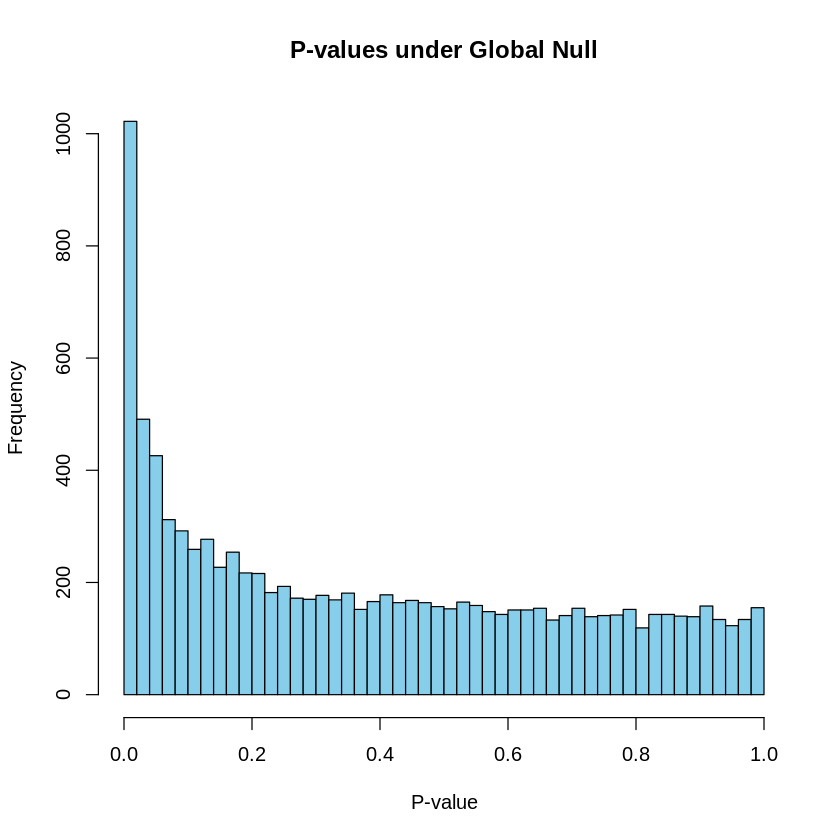

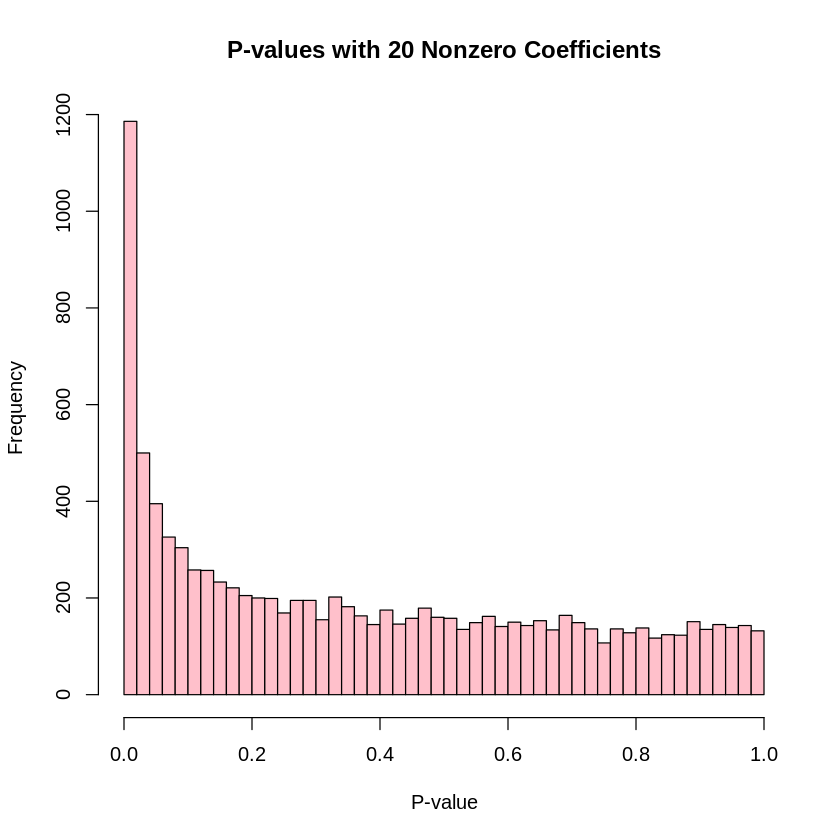

In [3]:

# Plot p-value distribution plot
p_values_global_null_vec <- unlist(p_values_global_null)
p_values_20_nonzero_vec <- unlist(p_values_20_nonzero)
hist(p_values_global_null_vec, breaks = 50, main = "P-values under Global Null", xlab = "P-value", col = "skyblue")
hist(p_values_20_nonzero_vec, breaks = 50, main = "P-values with 20 Nonzero Coefficients", xlab = "P-value", col = "pink")


In [4]:
#  Inflated p-value probabilities with estimated Monte Carlo standard errors
calculate_pvalue_probabilities <- function(p_values) {
  probs <- c(mean(p_values <= 0.05), mean(p_values <= 0.01), mean(p_values <= 0.001))
  ses <- sqrt(probs * (1 - probs) / length(p_values))
  return(cbind(probs, ses))
}

# For global null
global_null_probs <- calculate_pvalue_probabilities(p_values_global_null_vec)
# for 20 nonzero coefficients
nonzero_probs <- calculate_pvalue_probabilities(p_values_20_nonzero_vec)

# creat table
results_table <- data.frame(
  `P(p-value <= 5%)` = c(global_null_probs[1, "probs"], nonzero_probs[1, "probs"]),
  `SE(5%)` = c(global_null_probs[1, "ses"], nonzero_probs[1, "ses"]),
  `P(p-value <= 1%)` = c(global_null_probs[2, "probs"], nonzero_probs[2, "probs"]),
  `SE(1%)` = c(global_null_probs[2, "ses"], nonzero_probs[2, "ses"]),
  `P(p-value <= 0.1%)` = c(global_null_probs[3, "probs"], nonzero_probs[3, "probs"]),
  `SE(0.1%)` = c(global_null_probs[3, "ses"], nonzero_probs[3, "ses"])
)
row.names(results_table) <- c("Global Null", "20 Nonzero Coefficients")

# import table
knitr::kable(results_table, escape = FALSE)



|                        | P.p.value....5..|    SE.5..| P.p.value....1..|    SE.1..| P.p.value....0.1..|  SE.0.1..|
|:-----------------------|----------------:|---------:|----------------:|---------:|------------------:|---------:|
|Global Null             |           0.1728| 0.0037807|           0.0727| 0.0025964|             0.0217| 0.0014570|
|20 Nonzero Coefficients |           0.1885| 0.0039111|           0.0835| 0.0027664|             0.0238| 0.0015243|

Question 4

[[1]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "MASS"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

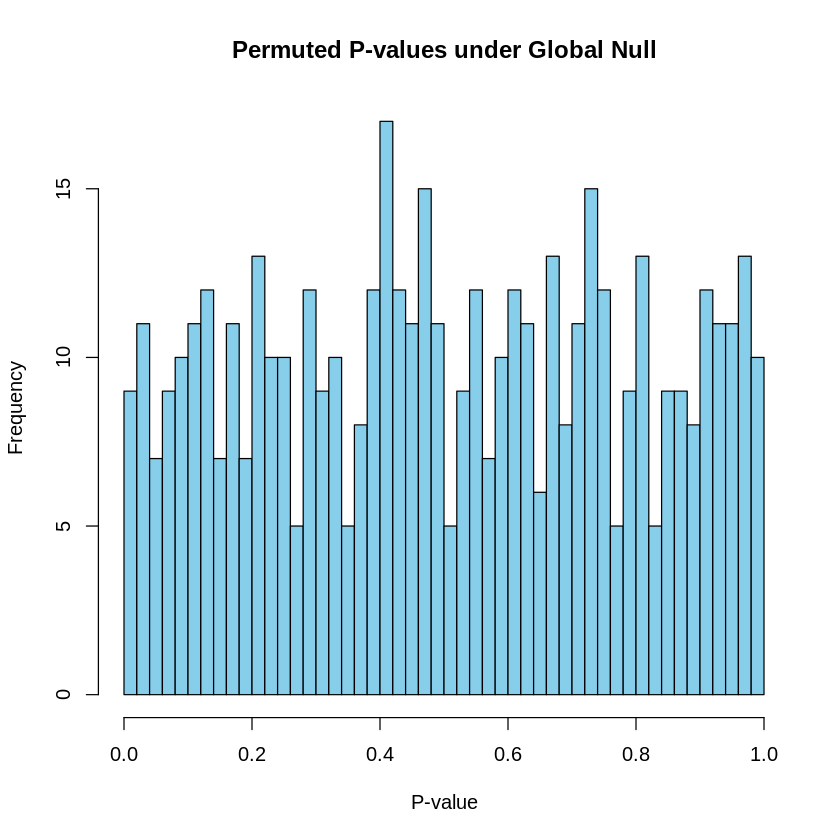

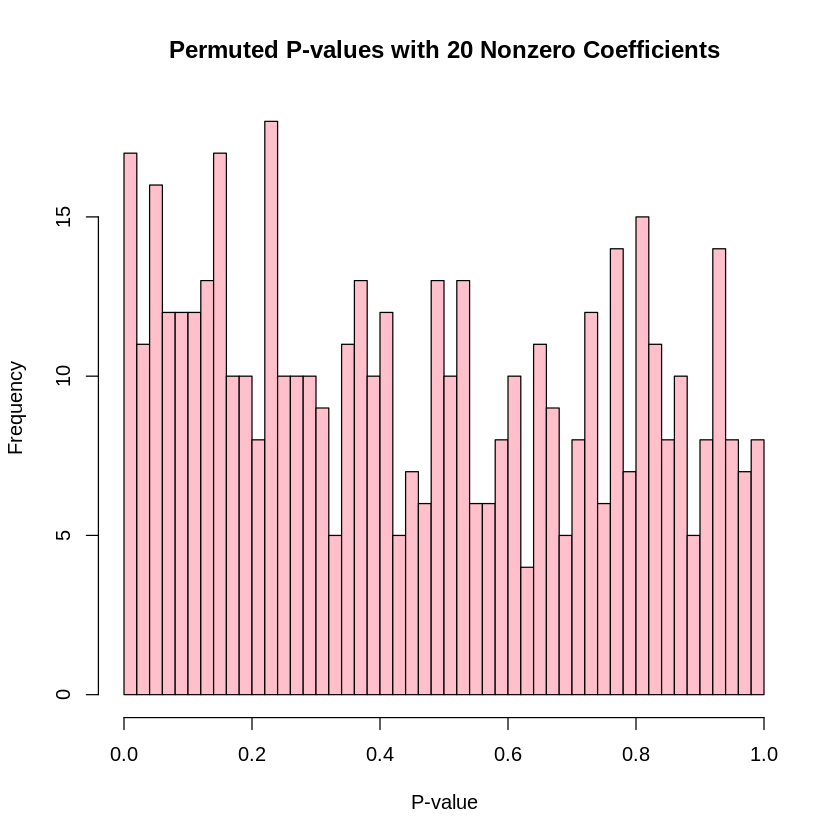

In [7]:
# simply copy code from Q1 and modify

simulate_and_fit_with_permutation <- function(n, p, num_nonnull, ar_coeff, scenario, num_perms = 100) {
  # Generate AR(1) structure
  Sigma <- outer(1:p, 1:p, FUN = function(i, j) ar_coeff^abs(i - j))
  # design matrix x and corresponding binary response variable y
  X <- MASS::mvrnorm(n = n, mu = rep(0, p), Sigma = Sigma)
  if (scenario == "global_null") {
    Y <- rbinom(n, 1, 0.5)
  } else if (scenario == "20_nonzero") {
    logit_p <- 0.08 * rowSums(X[, 2:21])
    prob <- exp(logit_p) / (1 + exp(logit_p))
    Y <- rbinom(n, 1, prob)
  } else {
    stop("Unknown scenario")
  }

  original_fit <- glm(Y ~ X, family = binomial())
  original_stat <- summary(original_fit)$coefficients[2, "z value"]

  # Permutation test
  perm_stats <- replicate(num_perms, {
    Y_perm <- sample(Y)
    perm_fit <- glm(Y_perm ~ X, family = binomial())
    summary(perm_fit)$coefficients[2, "z value"]
  })

  p_value <- sum(abs(perm_stats) >= abs(original_stat)) / num_perms
  return(p_value)
}

# Set parameters
n <- 500
p <- 200
ar_coeff <- 0.5
num_reps <- 500  # consider about coputational resource reduce repete times
num_perms <- 1000
cl <- makeCluster(detectCores() - 1)
clusterExport(cl, varlist = c("simulate_and_fit_with_permutation", "n", "p", "ar_coeff", "num_perms"))
clusterEvalQ(cl, {
  library(MASS)
})

# For global null
p_values_global_null_perm <- parLapply(cl, 1:num_reps, function(i) simulate_and_fit_with_permutation(n, p, 0, ar_coeff, "global_null", num_perms))

# 20 nonzero coefficients
p_values_20_nonzero_perm <- parLapply(cl, 1:num_reps, function(i) simulate_and_fit_with_permutation(n, p, 20, ar_coeff, "20_nonzero", num_perms))

stopCluster(cl)

# Plot p-value distribution plot
p_values_global_null_vec_perm <- unlist(p_values_global_null_perm)
p_values_20_nonzero_vec_perm <- unlist(p_values_20_nonzero_perm)
hist(p_values_global_null_vec_perm, breaks = 50, main = "Permuted P-values under Global Null", xlab = "P-value", col = "skyblue")
hist(p_values_20_nonzero_vec_perm, breaks = 50, main = "Permuted P-values with 20 Nonzero Coefficients", xlab = "P-value", col = "pink")


Question 5

In [25]:
# original without permutation
set.seed(23)

# load dataset
data <- read.csv("/content/PersonGaitDataSet.csv")

# set feature matrix and response variable
x <- as.matrix(data[, -ncol(data)]) # Feature matrix
y <- data$Label  # response variable

# split train data and test data
train_index <- c()
test_index <- c()
for (label in unique(y)) {
  label_indices <- which(y == label)
  train_index <- c(train_index, label_indices[1:length(label_indices)-1])
  test_index <- c(test_index, label_indices[length(label_indices)])
}

x_train <- x[train_index, ]
y_train <- y[train_index]
x_test <- x[test_index, ]
y_test <- y[test_index]

# train model
model <- svm(x_train, y_train, type = 'C-classification', kernel = 'linear')

# Evaluate the model on the test set
pred <- predict(model, x_test)
original_accuracy <- mean(pred == y_test)
print(paste("original accuracy:", original_accuracy))

[1] "original accuracy: 0.6875"


In [24]:
# Set parameters
n_permutations <- 1000
permuted_accuracies <- numeric(n_permutations)

# permutation test
for (i in 1:n_permutations) {
  feature_to_permute <- sample(colnames(data)[-ncol(data)], 1)
  x_train_permuted <- x_train
  x_train_permuted[, feature_to_permute] <- sample(x_train_permuted[, feature_to_permute])
  # retrain a new model using the permuted data
  model_permuted <- svm(x_train_permuted, y_train, type = 'C-classification', kernel = 'linear')
  # evaluate the permuted model using test data
  pred_permuted <- predict(model_permuted, x_test)
  permuted_accuracies[i] <- mean(pred_permuted == y_test)
}

# Print accuracy of permutation
mean_permuted_accuracy <- mean(permuted_accuracies)
print(paste("Mean permuted accuracy:", mean_permuted_accuracy))

# Performance differences for two situation
performance_difference <- original_accuracy - mean_permuted_accuracy
print(paste("Performance differences:", performance_difference))



[1] "Mean permuted accuracy: 0.6881875"
[1] "Performance differences: -0.000687499999999952"
